## Effects of the finite map size

We can try reducing the size of the box for a field with a given $r_0$ and see if $r_0$ is affected:

In [1]:
from pathlib import Path
import numpy as np
import json
from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
import cmasher as cmr
from matplotlib import pyplot as plt
import turbustat.statistics as tss
import turbustat.simulator
from turbustat.simulator import make_3dfield
from turb_utils import make_extended
import seaborn as sns
import sys

sys.path.append("..")
import strucfunc

sns.set_color_codes()
sns.set_context("talk")


def split4(arrs):
    """Split each 2D array in list into 4 quadrants

    Returns new list of all the quadrants from each input array.
    Requires that all axis lengths be even.
    """
    rslt = []
    for arr in arrs:
        for vsplit in np.vsplit(arr, 2):
            rslt.extend(np.hsplit(vsplit, 2))
    return rslt


a = np.arange(16).reshape((4, 4))
split4(split4([a]))

[array([[0]]),
 array([[1]]),
 array([[4]]),
 array([[5]]),
 array([[2]]),
 array([[3]]),
 array([[6]]),
 array([[7]]),
 array([[8]]),
 array([[9]]),
 array([[12]]),
 array([[13]]),
 array([[10]]),
 array([[11]]),
 array([[14]]),
 array([[15]])]

This function splits up the whole image into sub-images that are smaller (linearly) by `2**niter` and calculates the mean and std of the $\sigma^2$ and $r_0$ of them:



Copy functions from the seeing notebook.

In [11]:
def split_square_in_4(arr):
    ny, nx = arr.shape
    assert nx == ny and nx % 2 == 0
    slices = slice(None, nx // 2), slice(nx // 2, None)
    corners = []
    for i, j in [
        (0, 0),
        (0, 1),
        (1, 0),
        (1, 1),
    ]:
        corners.append(arr[slices[i], slices[j]])
    return corners

def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def values2arrays(d):
    for k in d.keys():
        if type(d[k]) == list:
            d[k] = np.array(d[k])
    return d

In [8]:
r0 = 32.0
N = 256
m = 1.2
vms_t = split_square_in_4(
    normalize(
        make_extended(
            2 * N,
            powerlaw=2.0 + m,
            ellip=0.5,
            theta=45,
            correlation_length=r0,
            randomseed=2021_10_08,
        )
    )
)

In [13]:

def split4_and_strucfuncs(arrs, niter=1):
    subarrs = arrs.copy()
    for i in range(niter):
        subarrs = split4(subarrs)
    BB = []
    sig2s = []
    r0s = []
    for subarr in subarrs:
        sf = strucfunc.strucfunc_numba_parallel(subarr, dlogr=0.05)
        mask = sf["N pairs"] > 0
        B = sf["Unweighted B(r)"][mask]
        BB.append(B)
        r = 10 ** sf["log10 r"][mask]
        sig2 = np.var(subarr)
        sig2s.append(sig2)
        try:
            i0 = np.argmax(r[B <= sig2])
            i1 = max(0, i0 - 2)
            i2 = min(len(B) - 1, i0 + 2)
            r0 = np.interp(sig2, B[i1:i2], r[i1:i2])
        except:
            r0 = np.nan
        r0s.append(r0)
    r0s = np.array(r0s)
    mgood = np.isfinite(r0s)
    Bmean = np.mean(np.stack(BB), axis=0)
    Bsig = np.std(np.stack(BB), axis=0)
    # calculate quartiles
    Bp25 = np.percentile(np.stack(BB), 25, axis=0)
    Bp75 = np.percentile(np.stack(BB), 75, axis=0)
    Bp05 = np.percentile(np.stack(BB), 5, axis=0)
    Bp95 = np.percentile(np.stack(BB), 95, axis=0)
    return {
        # "subarrs": subarrs,
        "r": r,
        "Bmean": Bmean,
        "Bsig": Bsig,
        "Bp05": Bp05,
        "Bp25": Bp25,
        "Bp75": Bp75,
        "Bp95": Bp95,
        "sig2mean": np.mean(sig2s),
        "sig2sig": np.std(sig2s),
        "sig2_25": np.percentile(sig2s, 25),
        "sig2_75": np.percentile(sig2s, 75),
        "r0mean": np.nanmean(r0s),
        "r0sig": np.nanstd(r0s),
        "r0_25": np.percentile(r0s[mgood], 25),
        "r0_75": np.percentile(r0s[mgood], 75),
    }


splits = {}
for k in [0, 1, 2, 3, 4, 5]:
    splits[2 ** k] = split4_and_strucfuncs(vms_t, k)

    
_split = splits[1]
true_r0 = np.interp(1.0, _split["Bmean"][:-4], _split["r"][:-4])


wdata = {
    "n": [],
    "r0mean": [],
    "r0sig": [],
    "sig2mean": [],
    "sig2sig": [],
}
for ii in splits.keys():
    wdata["n"].append(256 / ii)
    for v1 in "r0", "sig2":
        for v2 in "mean", "sig":
            v = v1 + v2
            wdata[v].append(splits[ii][v])
wdata = values2arrays(wdata)
wdata["r0mean"] /= true_r0
wdata["r0sig"] /= true_r0

bcolors = cmr.take_cmap_colors(
    "cmr.flamingo",
    len(splits.values()),
    cmap_range=(0.05, 0.75),
)

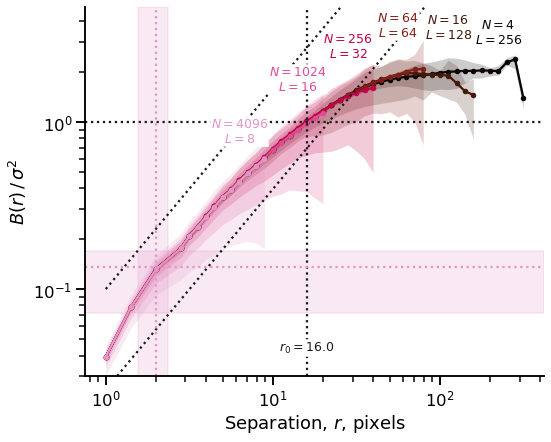

In [14]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)

whitebox = dict(color="white", alpha=1.0, pad=0.0)
L = 256
N = 2
for split, bcolor in zip(splits.values(), bcolors):
    line = ax.plot(split["r"], split["Bmean"], marker=".", color=bcolor)
    c = line[0].get_color()
    # ax.fill_between(
    #    split["r"],
    #    split["Bp05"],
    #    split["Bp95"],
    #    color=c, alpha=0.1, linewidth=0, zorder=-1,
    # )
    ax.fill_between(
        split["r"],
        split["Bp25"],
        split["Bp75"],
        color=c,
        alpha=0.2,
        linewidth=0,
        zorder=-1,
    )
    x, y = split["r"][-4], split["Bp75"][-4] * 1.3
    ax.text(
        x,
        y,
        (rf"$N = {N**2}$" "\n" rf"$L = {L}$"),
        color=c,
        ha="center",
        va="bottom",
        fontsize="x-small",
        bbox=whitebox,
    )
    L //= 2
    N *= 2
# ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.025, 0.1:
    ax.plot(rgrid, scale * rgrid ** m, linestyle="dotted", color="k")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0, color="k", linestyle="dotted")

# plot the range of derived r0 and sigma for smallest L
ax.axhline(split["sig2mean"], color=c, linestyle="dotted")
ax.axhspan(
    split["sig2_25"],
    split["sig2_75"],
    color=c,
    alpha=0.2,
)
ax.axvline(split["r0mean"], color=c, linestyle="dotted")
ax.axvspan(
    split["r0_25"],
    split["r0_75"],
    color=c,
    alpha=0.2,
)

ax.text(
    true_r0,
    0.04,
    rf"$r_0 = {true_r0:.1f}$",
    color="k",
    fontsize="x-small",
    ha="center",
    va="bottom",
    bbox=whitebox,
)
ax.set(
    xscale="log",
    yscale="log",
    ylim=[0.03, 4.9],
    xlabel=r"Separation, $r$, pixels",
    ylabel=r"$B(r) \, / \, \sigma^2$",
)
ax.set_aspect("equal")
sns.despine()
fig.tight_layout()
fig.savefig("fake-finite-box-strucfunc.pdf")

We have now changed this plot to use the 5, 25, 75, 95 centiles of the distributions. This is more realistic than using the mean +/- sigma, although it turns out to not make much difference.

I have also plotted the mean and quartiles of the r0 and sigma for the smallest box `L=8`, which gives $r_0 \approx L/4$

In [33]:
N = 256
vmap2x2_t = make_extended(
    2 * N,
    powerlaw=2.0 + m,
    ellip=0.5,
    theta=45,
    correlation_length=r0,
#    randomseed=2021_10_08,
    randomseed=2022_04_14,
)

In [34]:
normalize(vmap2x2_t)

array([[-0.55751135, -0.64742342, -0.9791921 , ..., -0.64840185,
        -0.42942507, -0.45788187],
       [-0.59883744, -0.54540943, -0.38650708, ..., -1.10868812,
        -0.65564721, -0.5459236 ],
       [-0.5945223 , -0.54402701, -0.37652341, ..., -1.31656778,
        -1.19139878, -0.7533807 ],
       ...,
       [-0.67849678, -0.51469626, -0.27788408, ..., -0.50628374,
        -0.43738645, -0.65497645],
       [-0.68873565, -0.56902098, -0.49500936, ..., -0.65125947,
        -0.6334967 , -0.48050705],
       [-0.56978276, -0.84715489, -0.99057408, ..., -0.75720943,
        -0.54524016, -0.48333512]])

In [35]:
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")

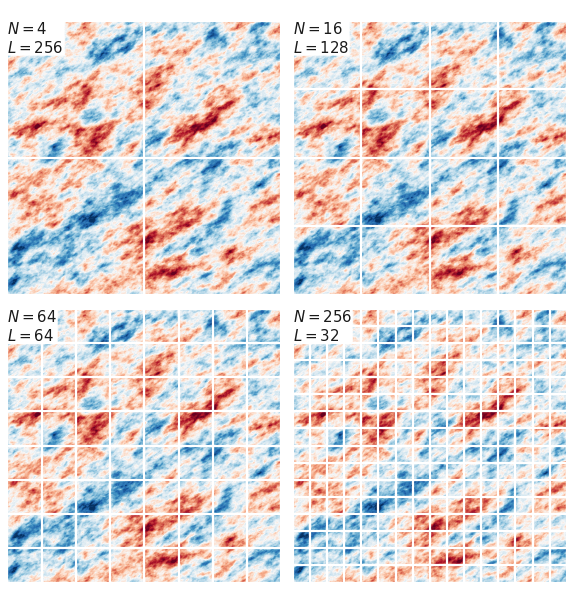

In [36]:
NN = 512
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, N in zip(axes.flat, [2, 4, 8, 16]):
    ax.imshow(
        normalize(vmap2x2_t), 
        **imshow_kwds,
    )
    ax.set(xticks=[], yticks=[])
    L = NN // N
    for i in range(N + 1):
        ax.axhline(i * L, color="w")
        ax.axvline(i * L, color="w")
    ax.text(
        0,
        NN,
        (rf"$N = {N**2}$" "\n" rf"$L = {L}$"),
        color="k",
        ha="left",
        va="top",
        fontsize="small",
        bbox=whitebox,
    )

sns.despine(left=True, bottom=True)
fig.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
fig.savefig("fake-finite-box-images.pdf")

In [37]:
N, m, r0

(16, 1.2, 32.0)

In [38]:
N = 256
vms_r16 = split_square_in_4(
    normalize(
        make_extended(
            2 * N,
            powerlaw=2.0 + m,
            ellip=0.5,
            theta=45,
            correlation_length=16,
            randomseed=2021_10_08,
        )
    )
)

splits_r16 = {}
for k in [0, 1, 2, 3, 4, 5]:
    splits_r16[2 ** k] = split4_and_strucfuncs(vms_r16, k)

../strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
../strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


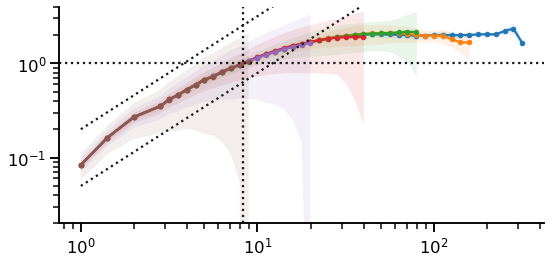

In [39]:
fig, ax = plt.subplots(
    figsize=(8, 4),
)

for split in splits_r16.values():
    line = ax.plot(split["r"], split["Bmean"], marker=".")
    c = line[0].get_color()
    ax.fill_between(
        split["r"],
        split["Bmean"] - split["Bsig"],
        split["Bmean"] + split["Bsig"],
        color=c,
        alpha=0.1,
        linewidth=0,
        zorder=-1,
    )
# ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.05, 0.2:
    ax.plot(rgrid, scale * rgrid ** m, linestyle="dotted", color="k")

_split = splits_r16[1]
true_r0_r16 = np.interp(1.0, _split["Bmean"][:-4], _split["r"][:-4])

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0_r16, color="k", linestyle="dotted")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[0.02, 4],
)
sns.despine()
fig.tight_layout()

In [40]:
wdata_r16 = {
    "n": [],
    "r0mean": [],
    "r0sig": [],
    "sig2mean": [],
    "sig2sig": [],
}
for ii in splits_r16.keys():
    wdata_r16["n"].append(256 / ii)
    for v1 in "r0", "sig2":
        for v2 in "mean", "sig":
            v = v1 + v2
            wdata_r16[v].append(splits_r16[ii][v])
wdata_r16 = values2arrays(wdata_r16)
wdata_r16["r0mean"] /= 0.5 * true_r0
wdata_r16["r0sig"] /= 0.5 * true_r0

In [41]:
vms_m15 = split_square_in_4(
    normalize(
        make_extended(
            2 * N,
            powerlaw=2.0 + 1.5,
            ellip=0.5,
            theta=45,
            correlation_length=16,
            randomseed=2021_10_08,
        )
    )
)

splits_m15 = {}
for k in [0, 1, 2, 3, 4, 5]:
    splits_m15[2 ** k] = split4_and_strucfuncs(vms_m15, k)

../strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
../strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


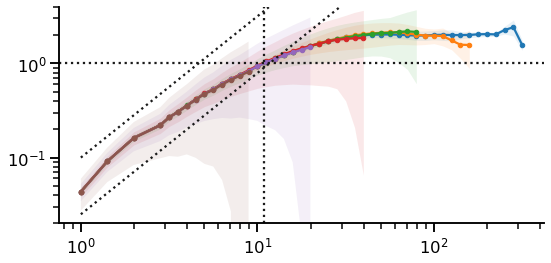

In [42]:
fig, ax = plt.subplots(
    figsize=(8, 4),
)

for split in splits_m15.values():
    line = ax.plot(split["r"], split["Bmean"], marker=".")
    c = line[0].get_color()
    ax.fill_between(
        split["r"],
        split["Bmean"] - split["Bsig"],
        split["Bmean"] + split["Bsig"],
        color=c,
        alpha=0.1,
        linewidth=0,
        zorder=-1,
    )
# ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.025, 0.1:
    ax.plot(rgrid, scale * rgrid ** 1.5, linestyle="dotted", color="k")

_split = splits_m15[1]
true_r0_m15 = np.interp(1.0, _split["Bmean"][:-4], _split["r"][:-4])

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0_m15, color="k", linestyle="dotted")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[0.02, 4],
)
sns.despine()
fig.tight_layout()

In [43]:
wdata_m15 = {
    "n": [],
    "r0mean": [],
    "r0sig": [],
    "sig2mean": [],
    "sig2sig": [],
}
for ii in splits_m15.keys():
    wdata_m15["n"].append(256 / ii)
    for v1 in "r0", "sig2":
        for v2 in "mean", "sig":
            v = v1 + v2
            wdata_m15[v].append(splits_m15[ii][v])
wdata_m15 = values2arrays(wdata_m15)
wdata_m15["r0mean"] /= true_r0_m15
wdata_m15["r0sig"] /= true_r0_m15

In [44]:
vms_m07 = split_square_in_4(
    normalize(
        make_extended(
            2 * N,
            powerlaw=2.0 + 0.666,
            ellip=0.5,
            theta=45,
            correlation_length=16,
            randomseed=2021_10_08,
        )
    )
)

splits_m07 = {}
for k in [0, 1, 2, 3, 4, 5]:
    splits_m07[2 ** k] = split4_and_strucfuncs(vms_m07, k)

../strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
../strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


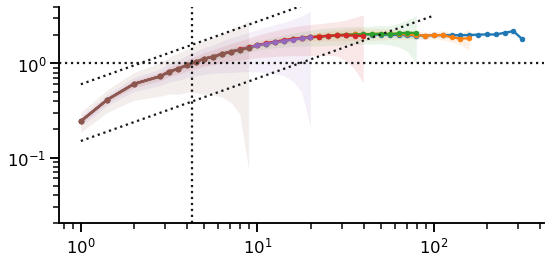

In [45]:
fig, ax = plt.subplots(
    figsize=(8, 4),
)

for split in splits_m07.values():
    line = ax.plot(split["r"], split["Bmean"], marker=".")
    c = line[0].get_color()
    ax.fill_between(
        split["r"],
        split["Bmean"] - split["Bsig"],
        split["Bmean"] + split["Bsig"],
        color=c,
        alpha=0.1,
        linewidth=0,
        zorder=-1,
    )
# ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.15, 0.6:
    ax.plot(rgrid, scale * rgrid ** 0.666, linestyle="dotted", color="k")

_split = splits_m07[1]
true_r0_m07 = np.interp(1.0, _split["Bmean"][:-4], _split["r"][:-4])

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0_m07, color="k", linestyle="dotted")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[0.02, 4],
)
sns.despine()
fig.tight_layout()

In [46]:
wdata_m07 = {
    "n": [],
    "r0mean": [],
    "r0sig": [],
    "sig2mean": [],
    "sig2sig": [],
}
for ii in splits_m07.keys():
    wdata_m07["n"].append(256 / ii)
    for v1 in "r0", "sig2":
        for v2 in "mean", "sig":
            v = v1 + v2
            wdata_m07[v].append(splits_m07[ii][v])
wdata_m07 = values2arrays(wdata_m07)
wdata_m07["r0mean"] /= true_r0_m07
wdata_m07["r0sig"] /= true_r0_m07

Empirical fit to the finite-box effect.  This turns out to be very simple:

In [47]:
def finite_box_effect(L_over_r0, scale=3.6):
    return 1 - np.exp(-L_over_r0 / scale)

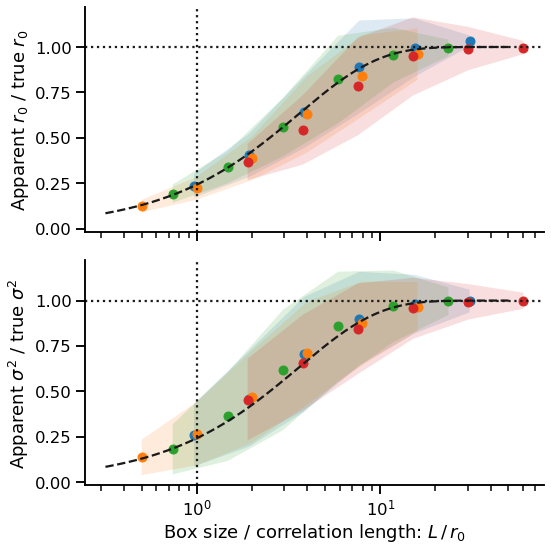

In [48]:
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    sharex=True,
    sharey=True,
    figsize=(8, 8),
)
for data, corr_length in [
    [wdata_r16, true_r0_r16],
    [wdata, true_r0],
    [wdata_m15, true_r0_m15],
    [wdata_m07, true_r0_m07],
]:
    x = data["n"] / corr_length
    ax1.plot(x, data["r0mean"], linestyle="none", marker="o")
    ax1.fill_between(
        x,
        data["r0mean"] - data["r0sig"],
        data["r0mean"] + data["r0sig"],
        alpha=0.15,
        lw=0,
        zorder=-1,
    )
    ax2.plot(x, data["sig2mean"], linestyle="none", marker="o")
    ax2.fill_between(
        x,
        data["sig2mean"] - data["sig2sig"],
        data["sig2mean"] + data["sig2sig"],
        alpha=0.15,
        lw=0,
        zorder=-1,
    )
xgrid = np.logspace(-0.5, 1.7, 200)
for ax in [ax1, ax2]:
    ax.axvline(1.0, color="k", linestyle="dotted")
    ax.axhline(1.0, color="k", linestyle="dotted")
    ax.plot(
        xgrid,
        finite_box_effect(xgrid, scale=3.6),
        color="k",
        linestyle="dashed",
    )


ax1.set(
    ylabel=r"Apparent $r_0$ / true $r_0$",
)
ax2.set(
    xscale="log",
    # yscale="log",
    # xlim=[1, 300],
    # ylim=[0, None],
    xlabel=r"Box size / correlation length: $L\, /\, r_0$",
    ylabel=r"Apparent $\sigma^2$ / true $\sigma^2$",
)
sns.despine()
fig.tight_layout()
fig.savefig("fake-finite-box-effect.pdf")

We find that the same function: $1 - \exp(-x / 3.6)$ is an adequate fit to both the $r_0$ and the $\sigma^2$ behaviors.

## Fake emissivity and velocity cubes

There is not such a rush to do these now, given that the pure velocity maps worked so well.